git repo source url - https://github.com/emanhamed/Houses-dataset

@article{ahmed2016house, title={House price estimation from visual and textual features}, author={Ahmed, Eman and Moustafa, Mohamed}, journal={arXiv preprint arXiv:1609.08399}, year={2016} }

## get attribute information about the houses and add them to the images of the houses
Attribute Information:Number of Bedrooms, Number of bathrooms, Area,Zipcod, Price

In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import locale
import pandas as pd
import os
import csv


cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv('./HousesDataset/HousesInfo.txt', sep=" ", header=None, names=cols)
zipcodes = df["zipcode"].value_counts().keys().tolist()
counts = df["zipcode"].value_counts().tolist()

# loop over each of the unique zip codes and their corresponding
# count

for (zipcode, count) in zip(zipcodes, counts):
    # the zip code counts for our housing dataset is *extremely*
    # unbalanced (some only having 1 or 2 houses per zip code)
    # so let's sanitize our data by removing any houses with less
    # than 25 houses per zip code
    if count < 25:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)

df.head()


Using TensorFlow backend.


,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000.0
32,3,2.0,1802,93446,365000.0
39,3,3.0,2146,93446,455000.0
80,4,2.5,2464,91901,599000.0
81,2,2.0,1845,91901,529800.0


In [2]:

def load_house_images(df, inputPath):
    # initialize our images array (i.e., the house images themselves)
    images = []
    idx=[]

    # loop over the indexes of the houses
    for i in df.index.values:
        # find the four images for the house and sort the file paths,
        # ensuring the four are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
        housePaths = sorted(list(glob.glob(basePath)))

        # initialize our list of input images along with the output image
        # after *combining* the four input images
        inputImages = []
        outputImage = np.zeros((128, 128, 3), dtype="uint8")

        # loop over the input house paths
        for housePath in housePaths:
            # load the input image, resize it to be 32 32, and then
            # update the list of input images
            image = cv2.imread(housePath)
            image = cv2.resize(image, (64, 64))
            inputImages.append(image)

        # tile the four input images in the output image such the first
        # image goes in the top-right corner, the second image in the
        # top-left corner, the third image in the bottom-right corner,
        # and the final image in the bottom-left corner
        outputImage[0:64, 0:64] = inputImages[0]
        outputImage[0:64, 64:128] = inputImages[1]
        outputImage[64:128, 64:128] = inputImages[2]
        outputImage[64:128, 0:64] = inputImages[3]
        idx.append(i)

        # add the tiled image to our set of images the network will be
        # trained on
        images.append(outputImage)

    # return our set of images
    return np.array(images), idx
images , idx= load_house_images(df, './HousesDataset/')
images = images / 255.0
images.shape

(362, 128, 128, 3)

In [12]:
idx[101]

211

     bedrooms  bathrooms  area  zipcode     price
210         5        3.0  3122    94501  899000.0


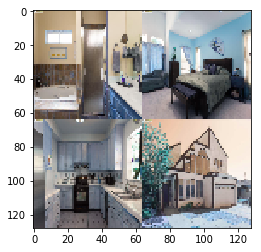

In [13]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
print(df.iloc[100:101,:])
rn=random.randint(0, len(images))
plt.imshow(images[100])
plt.show()


In [3]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization

#load vgg16 without dense layer and with theano dim ordering
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (128,128,3))

x = Flatten()(base_model.output)

print(type(x), x.shape)
model1 = Model(input = base_model.input, output = x)
out=model1.predict(images)
type(out),out.shape




<class 'tensorflow.python.framework.ops.Tensor'> (?, ?)


c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  if sys.path[0] == '':


(numpy.ndarray, (362, 8192))

In [4]:
split = train_test_split(df, out, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
trainImagesX.shape, testImagesX.shape,trainY.shape, testY.shape

((271, 8192), (91, 8192), (271,), (91,))

In [5]:

## function to prepare for combining images as well as the house attributes 
def process_house_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["bedrooms", "bathrooms", "area"]

    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    testCategorical = zipBinarizer.transform(test["zipcode"])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)


trainImagesX.shape, testImagesX.shape,trainY.shape, testY.shape

((271, 8192), (91, 8192), (271,), (91,))

In [6]:
### combine image data with house attributes to create trainX 
trainX,testX =process_house_attributes(df,trainAttrX, testAttrX)
trainX.shape, testX.shape , trainY.shape, testY.shape
X_train =np.hstack((trainImagesX, trainX)).reshape(271,8192+10,1)
X_test = np.hstack((testImagesX, testX)).reshape(91,8192+10,1)
trainY=trainY.values
testY=testY.values

X_train.shape, X_test.shape ,trainY.shape, testY.shape

((271, 8202, 1), (91, 8202, 1), (271,), (91,))

In [25]:

def create_cnn3(inputshape, filters=(16,32,64,128,256,512), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    #inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputshape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv1D(f,  3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling1D(pool_size=2)(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model


In [27]:
from keras.callbacks import ModelCheckpoint
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.convolutional import MaxPooling2D,MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
model = create_cnn3((8202,1), regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

epochs=300
# add checkpoint to save the model

checkpoint = ModelCheckpoint('./pretrained_CNN.hdf5', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# train the model
print("[INFO] training model...")
model.fit(X_train, trainY, validation_data=(X_test, testY),
	epochs=epochs, batch_size=12, callbacks=callbacks_list)

# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(X_test)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["price"].mean(), grouping=True),
    locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] training model...
Train on 271 samples, validate on 91 samples
Epoch 1/300
271/271 [==============================] - 64s 236ms/step - loss: 1935.5199 - val_loss: 7494.5863

Epoch 00001: val_loss improved from -inf to 7494.58625, saving model to ./pretrained_CNN.hdf5
Epoch 2/300
271/271 [==============================] - 45s 165ms/step - loss: 2088.0302 - val_loss: 4006.5991

Epoch 00002: val_loss did not improve from 7494.58625
Epoch 3/300
271/271 [==============================] - 44s 162ms/step - loss: 1875.6036 - val_loss: 3769.6964

Epoch 00003: val_loss did not improve from 7494.58625
Epoch 4/300
271/271 [==============================] - 49s 181ms/step - loss: 1301.1113 - val_loss: 1268.3730

Epoch 00004: val_loss did not improve from 7494.58625
Epoch 5/300
271/271 [==============================] - 44s 162ms/step - loss: 1001.3346 - val_loss: 1042.6006

Epoch 00005: val_loss did not improve from 7494.58625
Epoch 6/300
271/271 [==============================] - 46s 169ms/

271/271 [==============================] - 28s 104ms/step - loss: 53.5017 - val_loss: 56.2823

Epoch 00101: val_loss did not improve from 7494.58625
Epoch 102/300
271/271 [==============================] - 31s 115ms/step - loss: 52.3066 - val_loss: 57.4177

Epoch 00102: val_loss did not improve from 7494.58625
Epoch 103/300
271/271 [==============================] - 28s 105ms/step - loss: 53.5797 - val_loss: 59.1266

Epoch 00103: val_loss did not improve from 7494.58625
Epoch 104/300
271/271 [==============================] - 29s 107ms/step - loss: 52.6245 - val_loss: 63.2783

Epoch 00104: val_loss did not improve from 7494.58625
Epoch 105/300
271/271 [==============================] - 28s 102ms/step - loss: 58.3127 - val_loss: 59.3521

Epoch 00105: val_loss did not improve from 7494.58625
Epoch 106/300
271/271 [==============================] - 29s 109ms/step - loss: 53.9756 - val_loss: 60.2414

Epoch 00106: val_loss did not improve from 7494.58625
Epoch 107/300
271/271 [=============

271/271 [==============================] - 27s 101ms/step - loss: 41.1323 - val_loss: 64.4964

Epoch 00201: val_loss did not improve from 7494.58625
Epoch 202/300
271/271 [==============================] - 27s 100ms/step - loss: 39.0257 - val_loss: 68.2508

Epoch 00202: val_loss did not improve from 7494.58625
Epoch 203/300
271/271 [==============================] - 28s 102ms/step - loss: 38.9922 - val_loss: 64.9953

Epoch 00203: val_loss did not improve from 7494.58625
Epoch 204/300
271/271 [==============================] - 27s 99ms/step - loss: 41.2992 - val_loss: 81.1636

Epoch 00204: val_loss did not improve from 7494.58625
Epoch 205/300
271/271 [==============================] - 27s 98ms/step - loss: 40.9137 - val_loss: 78.1646

Epoch 00205: val_loss did not improve from 7494.58625
Epoch 206/300
271/271 [==============================] - 27s 99ms/step - loss: 38.7546 - val_loss: 67.6166

Epoch 00206: val_loss did not improve from 7494.58625
Epoch 207/300
271/271 [================

In [37]:
from keras.models import load_model

model.save('pretrained_CNN_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
m = load_model('pretrained_CNN_model.h5')

# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = m.predict(X_test)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, predicted avg house price: {}".format(
    locale.currency(testAttrX["price"].mean(), grouping=True),
    locale.currency(testAttrX["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%,  std: {:.2f}%".format(mean, std))

[INFO] predicting house prices...
[INFO] avg. house price: $560,483.11, predicted avg house price: $352,104.07
[INFO] mean: 59.80%,  std: 92.77%


In [33]:
model.fit(X_train, trainY, validation_data=(X_test, testY),
	epochs=100, batch_size=12, callbacks=callbacks_list)


Train on 271 samples, validate on 91 samples
Epoch 1/100
271/271 [==============================] - 27s 99ms/step - loss: 39.6550 - val_loss: 70.0522

Epoch 00001: val_loss did not improve from 7494.58625
Epoch 2/100
271/271 [==============================] - 28s 102ms/step - loss: 44.7708 - val_loss: 78.6250

Epoch 00002: val_loss did not improve from 7494.58625
Epoch 3/100
271/271 [==============================] - 27s 100ms/step - loss: 42.3383 - val_loss: 66.4204

Epoch 00003: val_loss did not improve from 7494.58625
Epoch 4/100
271/271 [==============================] - 28s 104ms/step - loss: 44.4172 - val_loss: 60.4514

Epoch 00004: val_loss did not improve from 7494.58625
Epoch 5/100
271/271 [==============================] - 27s 101ms/step - loss: 38.0408 - val_loss: 80.8885

Epoch 00005: val_loss did not improve from 7494.58625
Epoch 6/100
271/271 [==============================] - 28s 102ms/step - loss: 38.6921 - val_loss: 67.7469

Epoch 00006: val_loss did not improve from 7

In [7]:
from keras.models import load_model
from sklearn.metrics import mean_absolute_error 
#model.save('cnn3_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
m = load_model('pretrained_CNN_model.h5')

# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = m.predict(X_test)
preds=preds.flatten()
testY=testY.flatten()
error= mean_absolute_error(testY, preds)
# finally, show some statistics on our model
print("[INFO] mean abs error: {:.2f}%".format(error))

[INFO] predicting house prices...
[INFO] mean abs error: 0.05%


In [40]:
testAttrX.head(20)

,bedrooms,bathrooms,area,zipcode,price,pred
305,4,3.0,2570,92880,510000.0,126247.296875
110,4,3.0,3277,91901,669000.0,564465.937500
92,3,2.5,2836,91901,979000.0,569527.250000
464,3,3.0,2390,93446,769000.0,485429.375000
145,3,2.5,1655,92677,649900.0,518173.343750
324,4,2.5,2362,93510,539900.0,105745.343750
186,4,3.5,3485,94501,1895000.0,578084.062500
242,5,4.0,3500,92880,545000.0,524766.375000
409,3,2.0,1560,92276,189000.0,122984.054688
249,4,3.0,3000,92880,529900.0,610530.625000


c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,'sold house pricing')

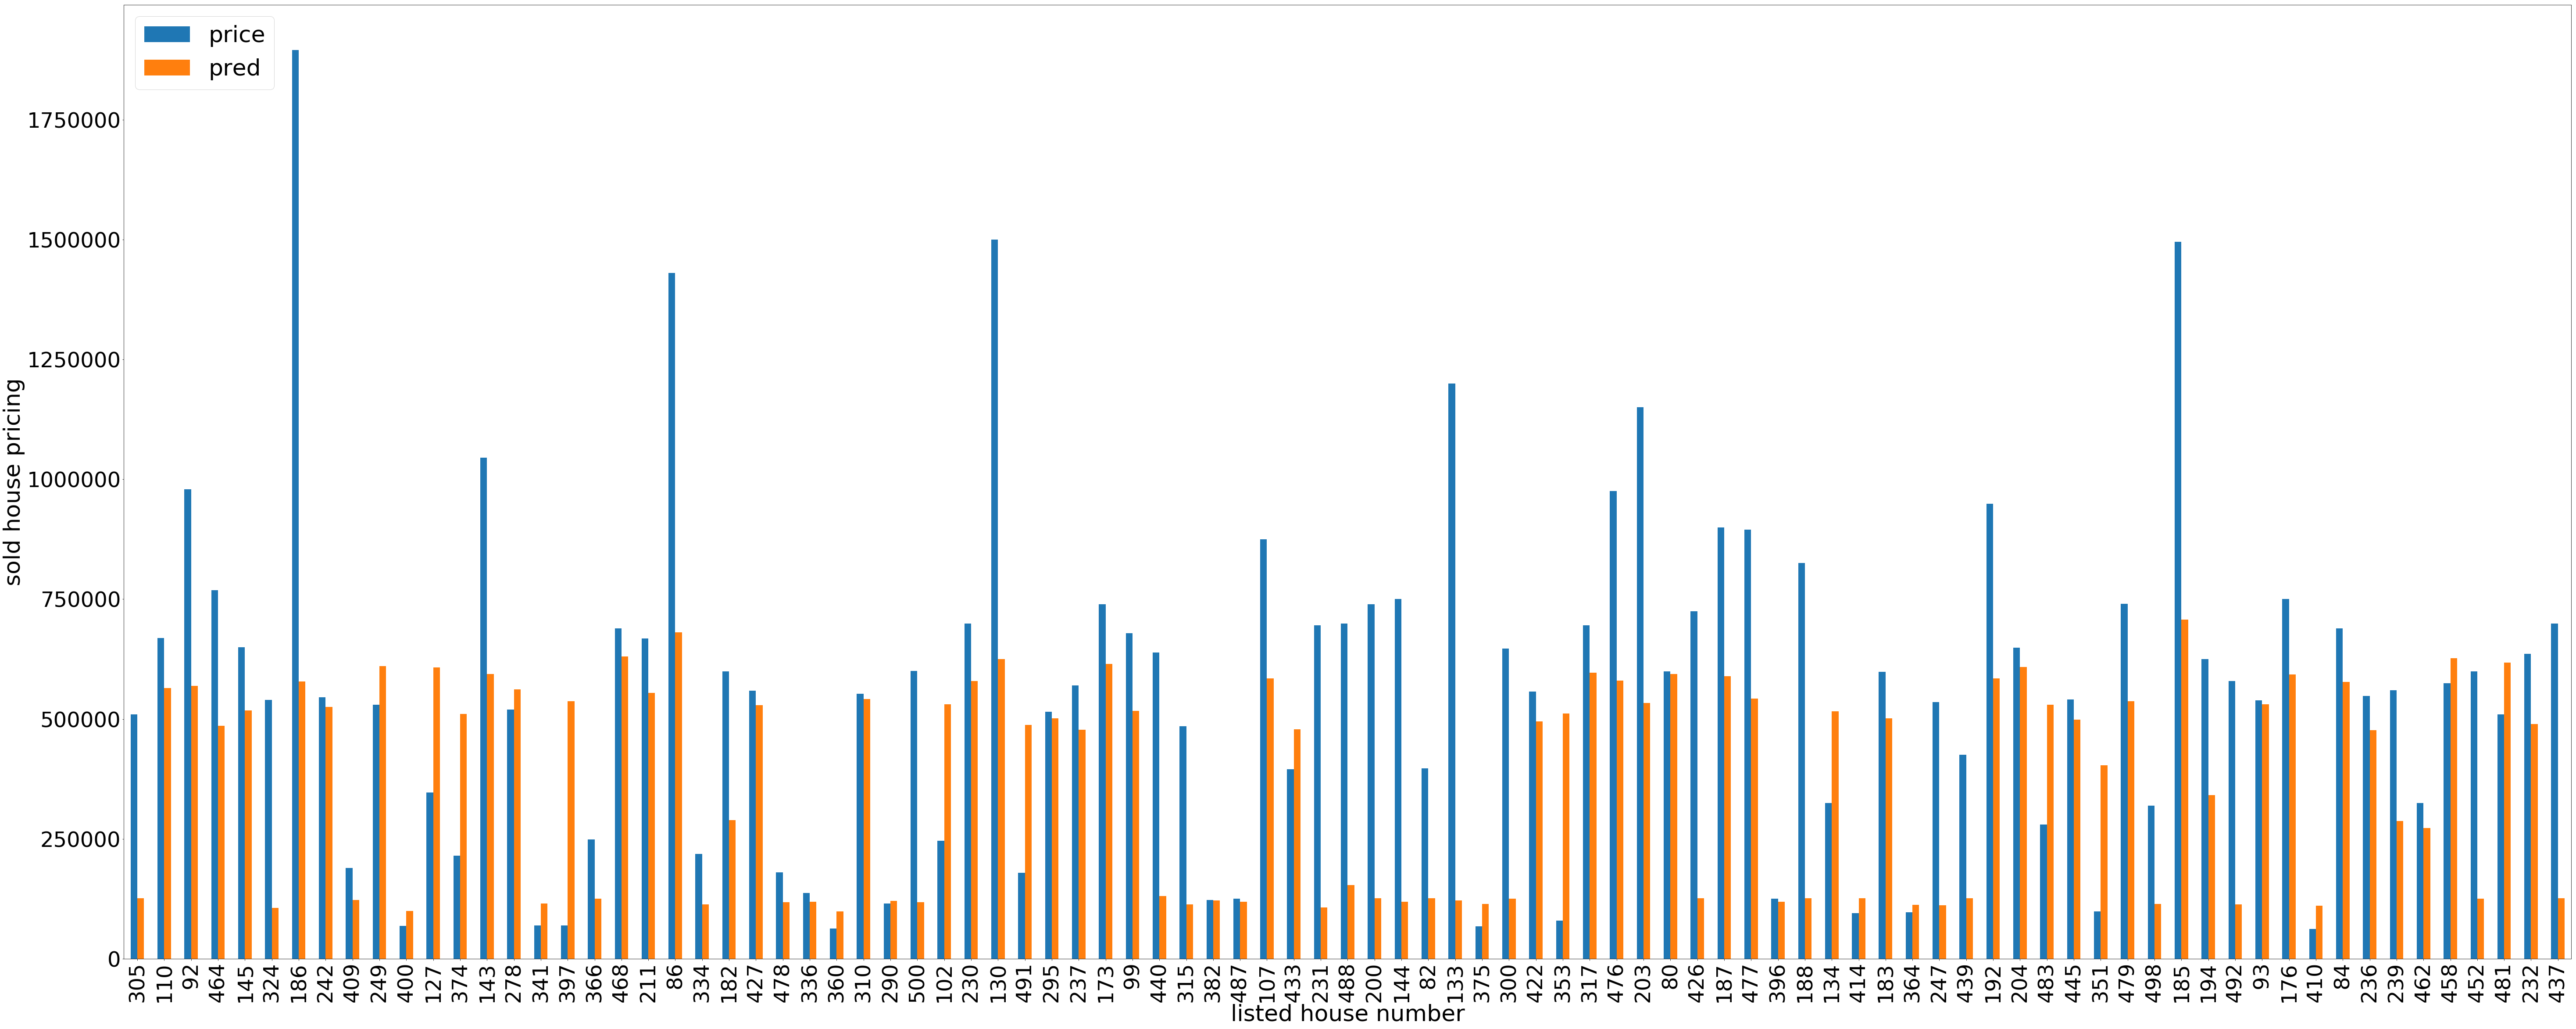

In [35]:
testAttrX['pred']=preds*maxPrice
#visualize the difference in actual sold price and predicted price
subdf=testAttrX[['price','pred']]

ax = subdf.plot.bar(rot=90,figsize=(100,40),fontsize =48, legend=True)
ax.legend(loc=2, prop={'size': 52})
ax.set_xlabel("listed house number", fontsize=52)
ax.set_ylabel("sold house pricing", fontsize=52)

c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,'percentage difference')

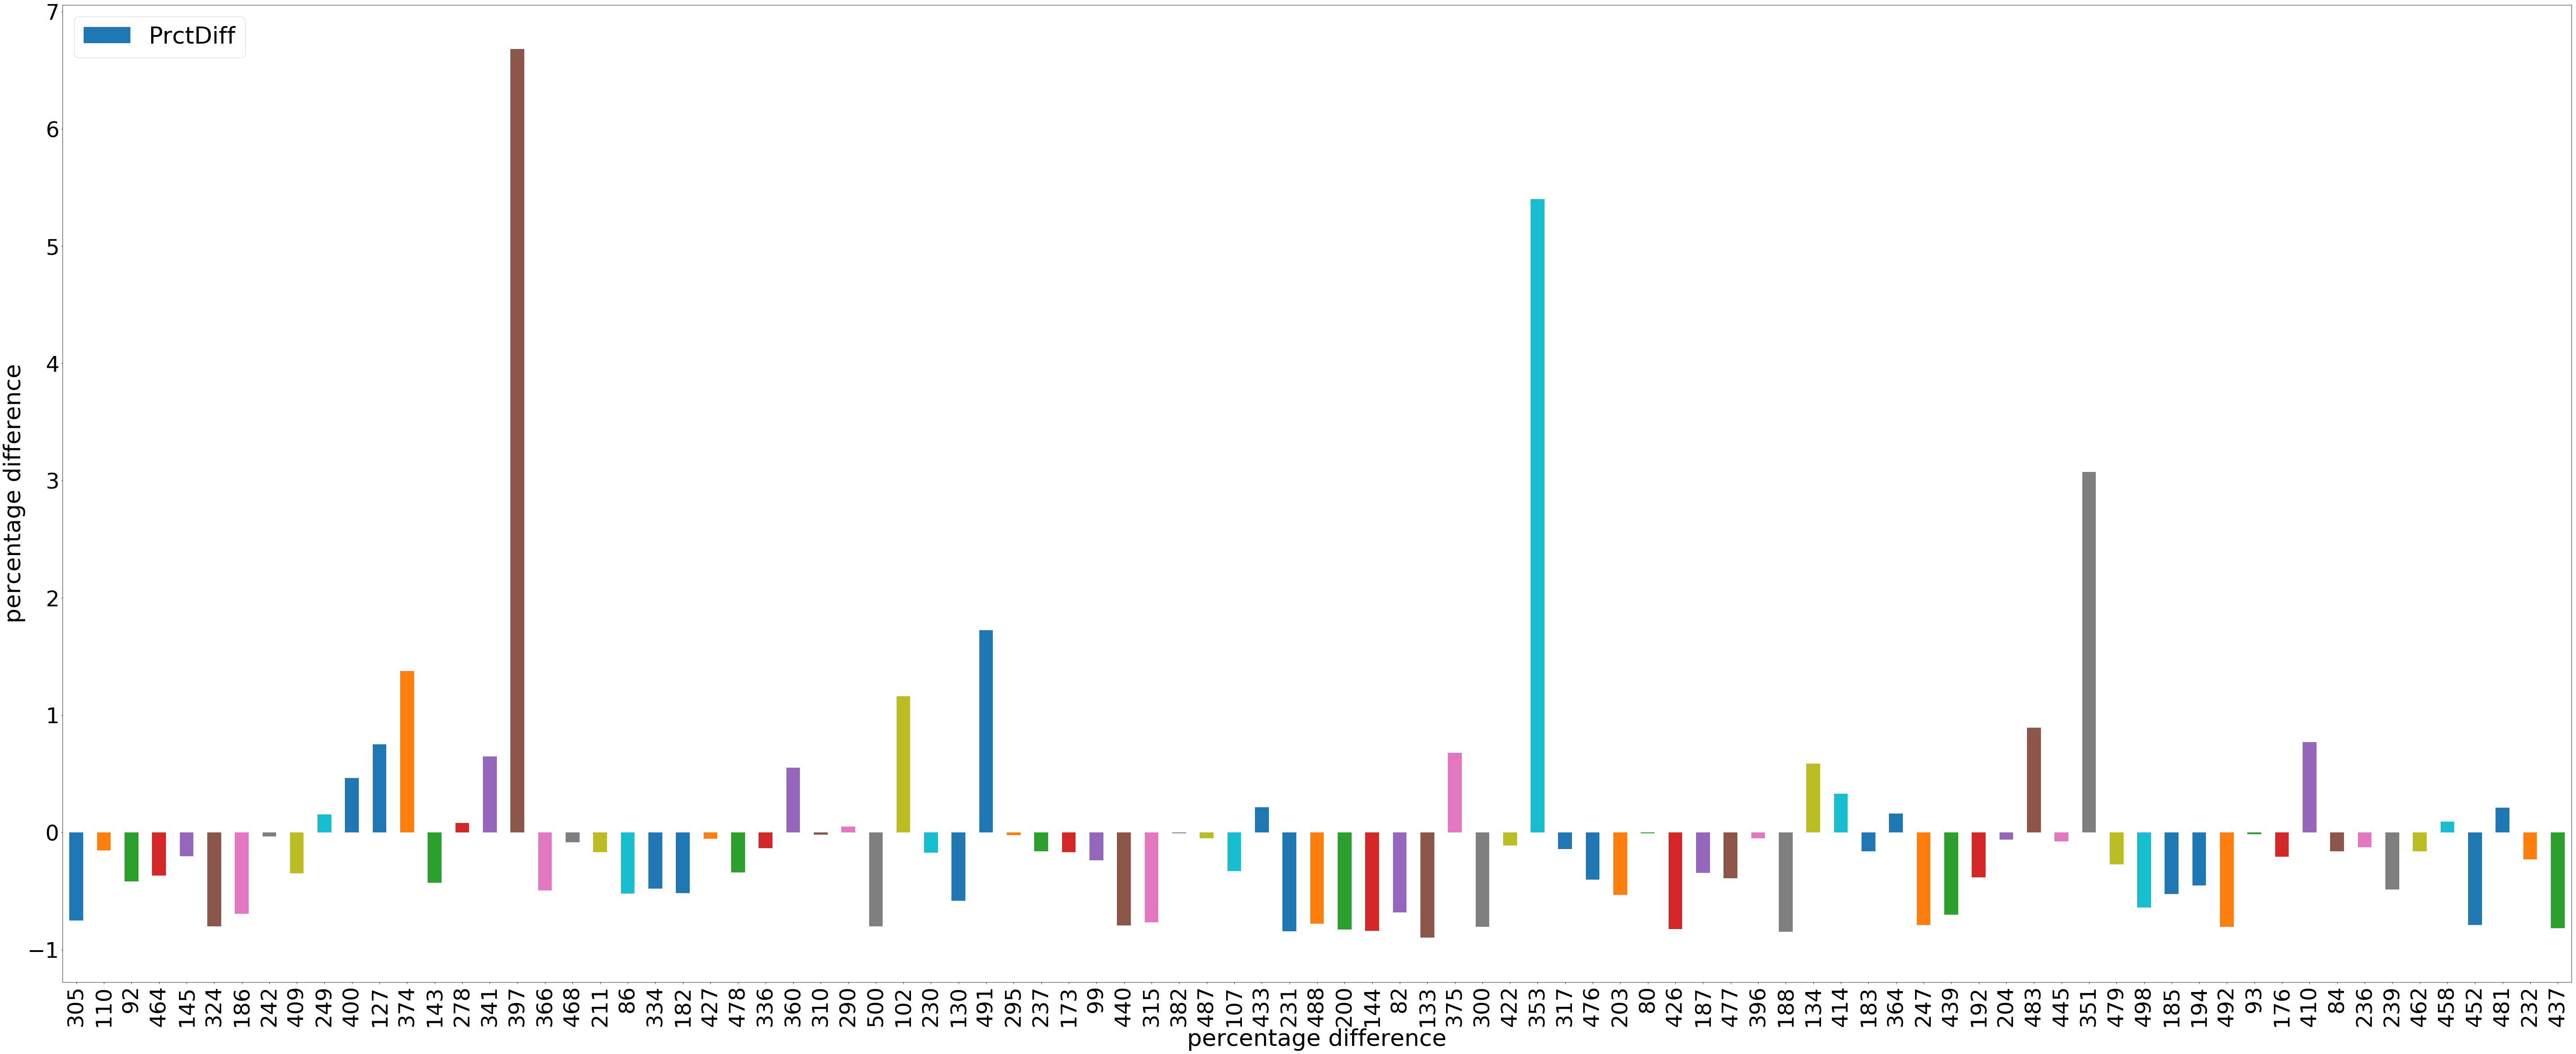

In [36]:
subdf['PrctDiff']=percentDiff/100
ax= subdf['PrctDiff'].plot.bar(rot=90,figsize=(100,40),fontsize =48, legend=True)
ax.legend(loc=2, prop={'size': 52})
ax.set_xlabel("percentage difference", fontsize=52)
ax.set_ylabel("percentage difference", fontsize=52)